In [1]:
from model.model import RecommenderSystemModel
from utils import get_categories, get_vector_diff_df
from data.data_preparation import get_model_df, get_items_df, get_users_df
from datetime import date
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import os
import itertools
warnings.filterwarnings("ignore")

In [2]:
# Sensitivity analysis configuration

steps = 360
run_type = "sensitivity"
today = date.today()

priority = [i/100 for i in range(0, 105, 10)] + get_categories()
ignorant_proportion = [0.5, 1.0]
social_influence = [False, True]

experimental_setups = itertools.product(priority, ignorant_proportion, social_influence)
experimental_setup = [
    {
        "priority": comb[0], 
        "ignorant_proportion": comb[1], 
        "social_influence": comb[2]
    } for comb in experimental_setups
]

fixed_setup = {
    "n_users": 150,
    "seed": 256788
}

In [3]:
# Static data gathering

df = get_model_df(**fixed_setup)
df.to_csv(f"data/sensitivity/static_sensitivity_df_{today}.csv")

Loading data...
    - Users loaded
    - Items loaded
    - Model dataframe ready. Interactions: 5757


In [4]:
# Simulation runs

if "df" not in globals():
    df = pd.read_csv(f"data/sensitivity/static_sensitivity_df_{today}.csv")

fixed_setup.update({"steps": steps, "df": df, "run_type": run_type})

for experiment in experimental_setup:
    run_setup = fixed_setup.copy()
    run_setup.update(experiment)
    print(f"Running experimental setup: {experiment}\n")
    rec_sys = RecommenderSystemModel(**run_setup)
    rec_sys.run_model()
print("\nSensitivity Analysis Finished!")

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 0.5, 'social_influence': True}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 1.0, 'social_influence': False}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 1.0, 'social_influence': True}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 0.5, 'social_influence': True}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 1.0, 'social_influence': False}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 1.0, 'social_influence': True}

Running experimental setup: {'priority': 0.2, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.2, 'ignorant_proportion': 0.5, 'social_infl

In [28]:
# Data analysis

# Data extraction

df_names = [f"{key}_{value}" for key, values in experimental_setup.items() for value in values]
df_names[0] = "benchmark"
dfs = []
base_path = "data/sensitivity"
entries = sorted(os.listdir(base_path))

for entry, name in zip(entries, df_names):
    full_path = os.path.join(base_path, entry)
    if os.path.isdir(full_path):
        results_path = os.path.join(full_path, "run_raw_1.csv")
        df_vectors = get_vector_diff_df(results_path)
        df_vectors["experiment"] = name
        dfs.append(df_vectors)

df_all_vector_diff = pd.concat(dfs, ignore_index=True)

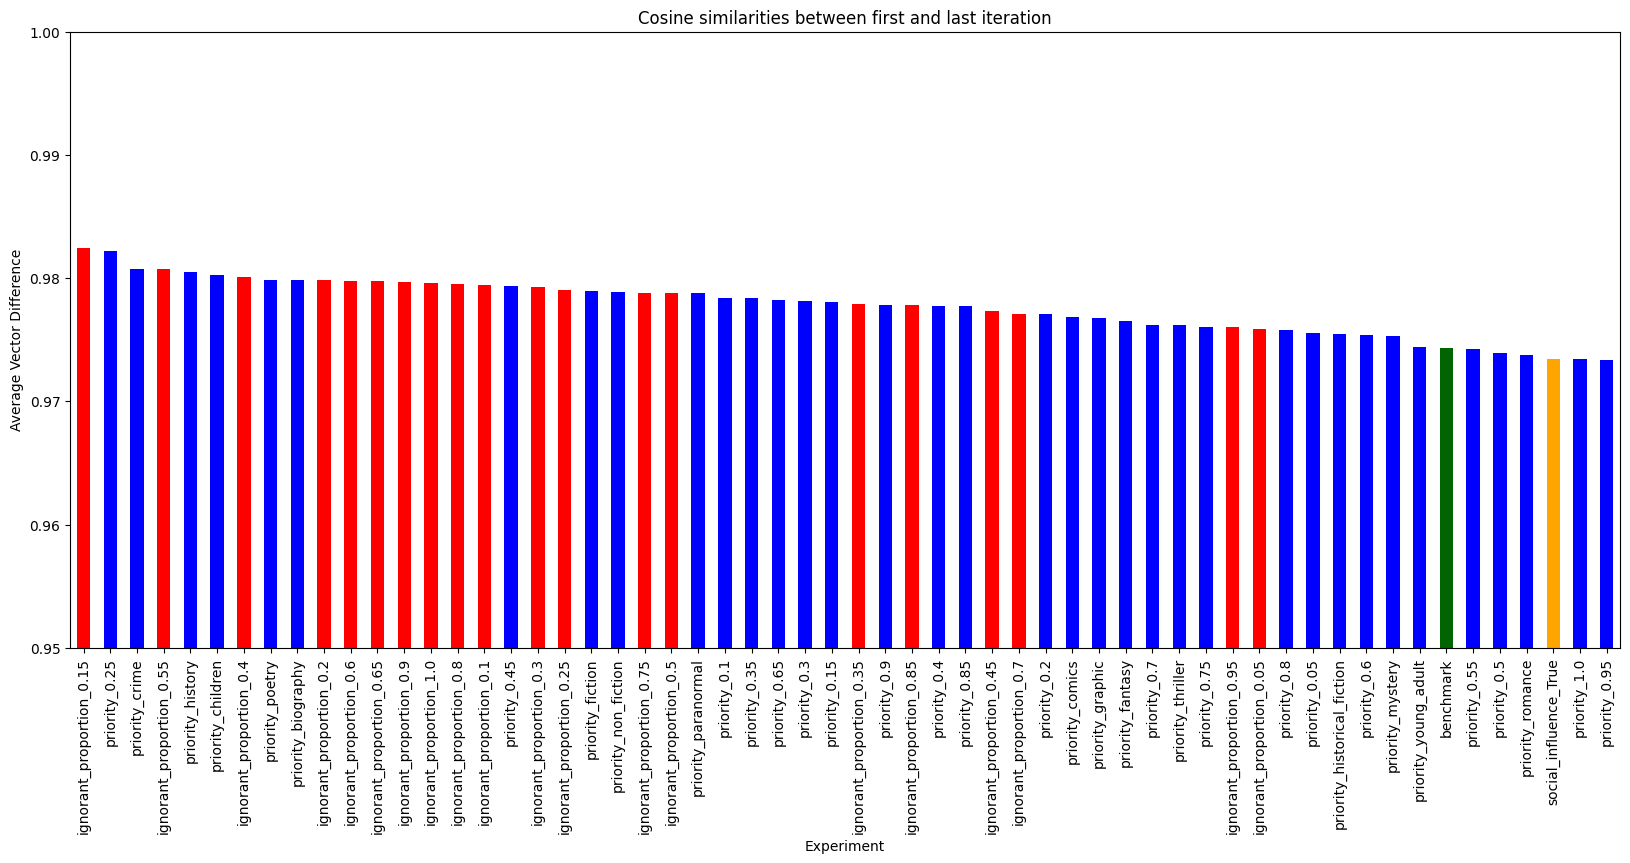

In [32]:
# Plot average differences

df_all_vector_diff_mean = df_all_vector_diff.groupby("experiment")["vector_diff"].mean().sort_values(ascending=False)
color_mapping = {"priority": "blue", "ignorant": "red", "social": "orange", "benchmark": "darkgreen"}
colors = [color_mapping[x.split("_")[0]] for x in df_all_vector_diff_mean.index]

plt.figure(figsize=(20,8))
df_all_vector_diff_mean.plot(kind="bar", color=colors)
plt.xlabel("Experiment")
plt.ylabel("Average Vector Difference")
plt.title("Cosine similarities between first and last iteration")
plt.xticks(rotation=90)
plt.ylim(0.95, 1)
plt.show()

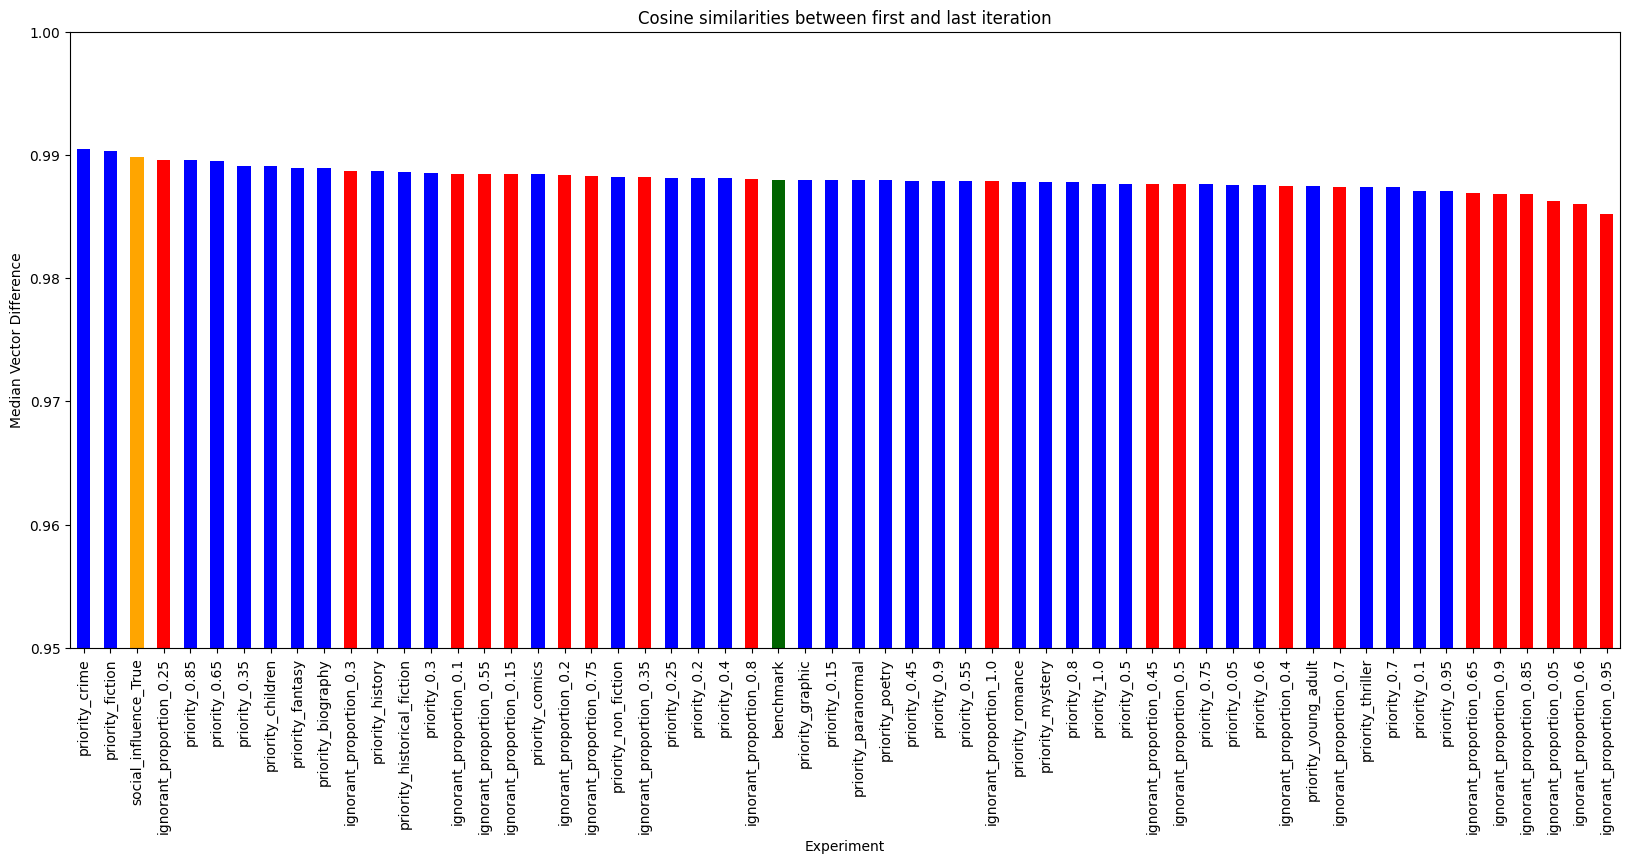

In [33]:
# Plot median differences

df_all_vector_diff_mean = df_all_vector_diff.groupby("experiment")["vector_diff"].median().sort_values(ascending=False)
color_mapping = {"priority": "blue", "ignorant": "red", "social": "orange", "benchmark": "darkgreen"}
colors = [color_mapping[x.split("_")[0]] for x in df_all_vector_diff_mean.index]

plt.figure(figsize=(20,8))
df_all_vector_diff_mean.plot(kind="bar", color=colors)
plt.xlabel("Experiment")
plt.ylabel("Median Vector Difference")
plt.title("Cosine similarities between first and last iteration")
plt.xticks(rotation=90)
plt.ylim(0.95, 1)
plt.show()